# [**Importance de permutation vs. Importance de caractéristique de forêt aléatoire (MDI)**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/4_inspection/plot_permutation_importance.ipynb)<br/>([*Permutation Importance vs Random Forest Feature Importance (MDI)*](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html))

Dans cet exemple, nous allons comparer l'importance des caractéristiques basée sur les impuretés de [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) avec l'importance de la permutation sur l'ensemble de données du Titanic à l'aide de [`permutation_importance`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance). Nous montrerons que l'importance des caractéristiques basées sur les impuretés peut gonfler l'importance des caractéristiques numériques.

De plus, l'importance des caractéristiques basée sur les impuretés des forêts aléatoires souffre du fait qu'elle est calculée sur des statistiques dérivées de l'ensemble de données d'apprentissage : les importances peuvent être élevées même pour les caractéristiques qui ne sont pas prédictives de la variable cible, tant que le modèle a la capacité de les utiliser pour surajuster.

Cet exemple montre comment utiliser les importances de permutation comme alternative pouvant atténuer ces limitations.

**Référence**

[B2001] L. Breiman, [“**Random Forests**](https://link.springer.com/content/pdf/10.1023/A:1010933404324.pdf)[”](https://drive.google.com/file/d/1Kb5Z81PDb2d_HGi0OBzJjWOzIq834G0y/view?usp=share_link), Machine Learning, 45(1), 5-32, 2001.

In [1]:
import numpy as np

# Chargement de données et ingénierie des caractéristiques

Utilisons pandas pour charger une copie du jeu de données du Titanic. Ce qui suit montre comment appliquer un prétraitement séparé sur les caractéristiques numériques et catégorielles.

Nous incluons en outre deux variables aléatoires qui ne sont en aucune façon corrélées avec la variable cible (`survived`) :

* `random_num` est une variable numérique à cardinalité élevée (autant de valeurs uniques que d'enregistrements).
* `random_cat` est une variable catégorielle de faible cardinalité (3 valeurs possibles).

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X["random_cat"] = rng.randint(3, size=X.shape[0])
X["random_num"] = rng.randn(X.shape[0])

categorical_columns = ["pclass", "sex", "embarked", "random_cat"]
numerical_columns = ["age", "sibsp", "parch", "fare", "random_num"]

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Nous définissons un modèle prédictif basé sur une forêt aléatoire. Par conséquent, nous effectuerons les étapes de prétraitement suivantes :
* utiliser [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) pour coder les caractéristiques catégorielles ;
* utiliser [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) pour remplir les valeurs manquantes pour les caractéristiques numériques en utilisant une stratégie moyenne.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

# Précision du modèle

Avant d'inspecter l'importance des caractéristiques, il est important de vérifier que les performances prédictives du modèle sont suffisamment élevées. En effet, il y aurait peu d'intérêt à inspecter les caractéristiques importantes d'un modèle non prédictif.

Ici, on peut observer que la précision de l'apprentissage est très élevée (le modèle de forêt a une capacité suffisante pour mémoriser complètement l'ensemble d'apprentissage) mais il peut toujours assez bien généraliser à l'ensemble de test grâce au bagging intégré de forêts aléatoires.

Il pourrait être possible d'échanger une certaine précision sur l'ensemble d'apprentissage contre une précision légèrement meilleure sur l'ensemble de test en limitant la capacité des arbres (par exemple en définissant `min_samples_leaf=5` ou `min_samples_leaf=10`) afin de limiter le surajustement tout en n'introduisant pas trop de sous-ajustement.

Cependant, gardons notre modèle de forêt aléatoire à haute capacité pour l'instant afin d'illustrer certains pièges avec l'importance des caractéristiques sur des variables avec de nombreuses valeurs uniques.

In [5]:
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.814


# Importance des caractéristiques de l'arbre à partir de la diminution moyenne des impuretés (MDI)

L'importance des caractéristiques basée sur les impuretés classe les caractéristiques numériques comme étant les caractéristiques les plus importantes. En conséquence, la variable `random_num` non prédictive est classée comme l'une des caractéristiques les plus importantes !

Ce problème découle de deux limitations de l'importance des caractéristiques basées sur les impuretés :

* les importances basées sur les impuretés sont biaisées vers les caractéristiques de cardinalité élevée ;
* les importances basées sur les impuretés sont calculées sur les statistiques de l'ensemble d'apprentissage et ne reflètent donc pas la capacité de la caractéristique à être utile pour faire des prédictions qui se généralisent à l'ensemble de test (lorsque le modèle a une capacité suffisante).

Le biais vers les caractéristiques de cardinalité élevée explique pourquoi `random_num` a une très grande importance par rapport à `random_cat` alors que nous nous attendrions à ce que les deux caractéristiques aléatoires aient une importance nulle.

Le fait que nous utilisions des statistiques sur les ensembles d'apprentissage explique pourquoi les caractéristiques `random_num` et `random_cat` ont une importance non nulle.

In [6]:
import pandas as pd

feature_names = rf[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

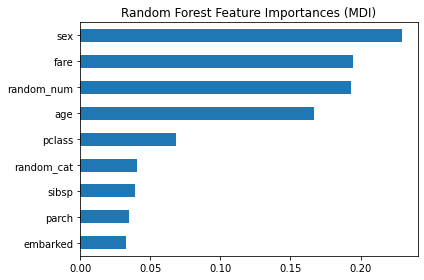

In [7]:
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

Comme alternative, les importances de permutation de `rf` sont calculées sur un jeu de test retenu. Cela montre que la caractéristique catégorielle de faible cardinalité, `sex` et `pclass` sont les caractéristiques les plus importantes. En effet, permuter les valeurs de ces caractéristiques conduira à la plus grande diminution du score de précision du modèle sur l'ensemble de test.

Notez également que les deux caractéristiques aléatoires ont des importances très faibles (proche de 0) comme prévu.

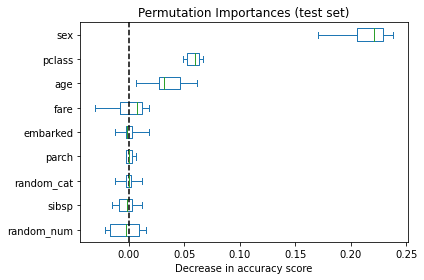

In [8]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

Il est également possible de calculer les importances des permutations sur l'ensemble d'apprentissage. Cela révèle que `random_num` et `random_cat` obtiennent un classement d'importance significativement plus élevé que lorsqu'ils sont calculés sur l'ensemble de test. La différence entre ces deux tracés est une confirmation que le modèle RF a une capacité suffisante pour utiliser ces caractéristiques numériques et catégorielles aléatoires pour sur-ajuster.

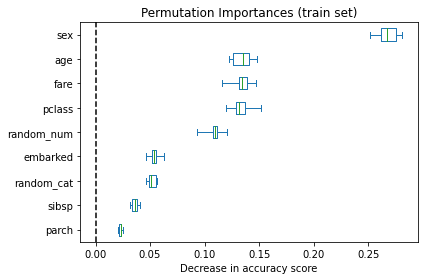

In [9]:
result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

Nous pouvons encore retenter l'expérience en limitant la capacité des arbres à sur-adapter en définissant `min_samples_leaf` à 20 points de données.

In [10]:
rf.set_params(classifier__min_samples_leaf=20).fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=20, random_state=42))])

En observant le score de précision sur l'ensemble d'entraînement et de test, nous observons que les deux métriques sont maintenant très similaires. Par conséquent, notre modèle n'est plus surajusté. On peut alors vérifier les importances des permutations avec ce nouveau modèle.

In [11]:
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 0.810
RF test accuracy: 0.832


In [12]:
train_result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
test_results = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_importances_idx = train_result.importances_mean.argsort()

In [13]:
train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

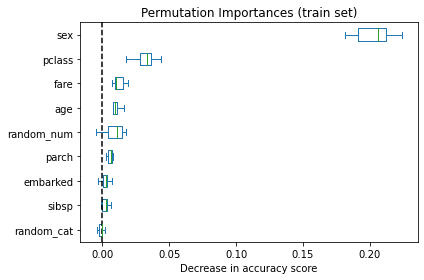

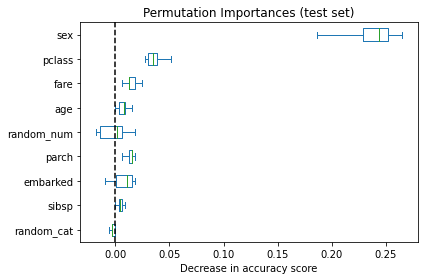

In [14]:
for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

Maintenant, nous pouvons observer que sur les deux ensembles, les caractéristiques `random_num` et `random_cat` ont une importance moindre par rapport à la forêt aléatoire surajustée. Cependant, les conclusions concernant l'importance des autres caractéristiques sont toujours valables.